In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from haversine import haversine

In [15]:
# 데이터 주소
DATA_PATH = "./data/train.csv"

#데이터를 DataFram의 형태로 불러옵니다.
def load_csv(path):
    data_frame = pd.read_csv(path)
    return data_frame

In [16]:
# 결측치 처리 함수입니다.
def del_missing(df):
    # del_un_id_df의 누락된 데이터가 있는 행을 제거하고 removed_df에 저장합니다.
    removed_df = df.dropna()
    
    return removed_df

# 리스트를 입력으로 받아서 해당 리스트 내에 음수값이 있으면 그 위치(인덱스)들을 리스트로 출력하는 함수를 만듭니다.
def get_negative_index(list_data):
    neg_idx = []
    
    for i, value in enumerate(list_data):
        if value < 0:
            neg_idx.append(list_data.index[i])
            
    return neg_idx

# DataFrame 내에 제거해야 하는 이상치의 인덱스를 반환하는 함수를 만듭니다.
def outlier_index():
    # get_negative_index() 함수를 통해서, fare_amount와 passenger_count 내의 음수값들의 인덱스를 반환합니다.
    idx_fare_amount = get_negative_index(fare_amount)
    idx_passenger_count = get_negative_index(passenger_count)
    
    idx_zero_distance = []    
    idx = [i for i in range(len(passenger_count))]
    zipped = zip(idx, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)
    
    for i, x, y, _x, _y in zipped:
        # 타는 곳(pickup_longitude,pickup_latitude)과 내리는 곳(drop_longitude, drop_latitude)이 같은 데이터의 인덱스를 idx_zero_distance에 저장합니다.
        if (x == _x) and (y == _y):
            idx_zero_distance.append(i)
        elif (x > 90) or (x <-90):
            idx_zero_distance.append(i)
        elif (_x > 90) or (_x <-90):
            idx_zero_distance.append(i)
        elif (y > 90) or (y <-90):
            idx_zero_distance.append(i)
        elif (_y > 90) or (_y <-90):
            idx_zero_distance.append(i)
            
    total_index4remove = list(set(idx_fare_amount+idx_passenger_count+idx_zero_distance))
    
    return total_index4remove

# 인덱스를 기반으로 DataFrame 내의 데이터를 제거하고, 제거된 DataFrame을 반환하는 함수를 만듭니다.
def remove_outlier(dataframe, list_idx):
    return dataframe.drop(list_idx)

df = load_csv(DATA_PATH)
print(df.head())
#df.info()

# 1-1. del_missing 함수로 df의 결측치을 처리하여 df에 덮어씌웁니다.
df = del_missing(df)

# 불러온 DataFrame의 각 인덱스의 값들을 변수로 저장합니다.
fare_amount = df['fare_amount']
passenger_count = df['passenger_count']
pickup_longitude = df['pickup_longitude']
pickup_latitude = df['pickup_latitude']
dropoff_longitude = df['dropoff_longitude']
dropoff_latitude = df['dropoff_latitude']

# 1-2. remove_outlier()을 사용하여 이상치를 제거합니다.
# remove_outlier()가 어떤 인자들을 받는지 확인하세요.
remove_index = outlier_index()
df = remove_outlier(df, remove_index)

#print(df.head())
#df.info()


                             key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3       

In [17]:
df['start_p'] = df.apply(lambda row: (row['pickup_latitude'], row['pickup_longitude']), axis=1)
df['end_p'] = df.apply(lambda row: (row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

df['distance_km'] = df.apply(lambda row: haversine(row['start_p'], row['end_p'], unit='km'), axis=1)
df['distance_mi'] = df.apply(lambda row: haversine(row['start_p'], row['end_p'], unit='mi'), axis=1)

#print(df.head())

#이상치를 찾아내기 위해서 사용한 describe
print(df.describe())

        fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  48544.000000      48544.000000     48544.000000       48544.000000   
mean      11.367205        -73.858921        40.669056         -73.855147   
std        9.561290          3.230205         2.578711           3.260349   
min        0.000000        -75.423848       -74.006893         -84.654241   
25%        6.000000        -73.992300        40.736422         -73.991325   
50%        8.500000        -73.982125        40.753387         -73.980477   
75%       12.500000        -73.968426        40.767739         -73.965336   
max      200.000000         40.783472        43.098708          40.851027   

       dropoff_latitude  passenger_count   distance_km   distance_mi  
count      48544.000000     48544.000000  48544.000000  48544.000000  
mean          40.669583         1.670361     18.885252     11.734752  
std            2.579559         1.291745    358.711696    222.893114  
min          -74.00637

c:\Users\302-09\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128662 (\N{ONCOMING TAXI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


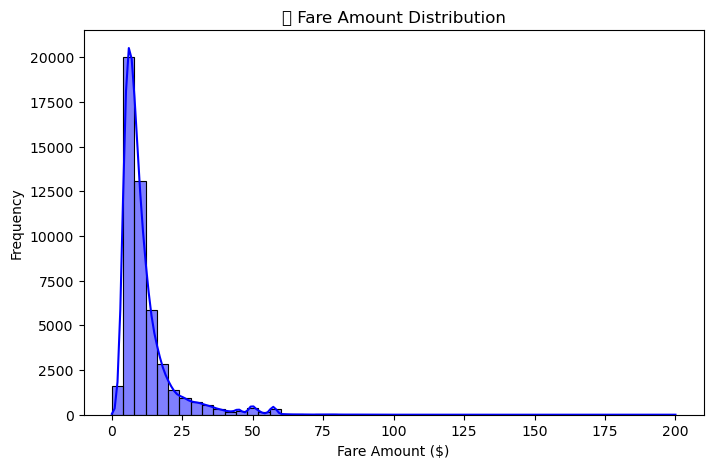

In [18]:
# 히스토그램과 커널 밀도 그래프
plt.figure(figsize=(8,5))
sns.histplot(df['fare_amount'], bins=50, kde=True, color='blue')
plt.title("🚖 Fare Amount Distribution")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.show()

In [19]:
# 독립 변수 (X) 및 종속 변수 (y) 설정
X = df[['distance_km', 'passenger_count']]
y = df['fare_amount']

# train_test_split 적용 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 훈련 데이터프레임 생성 (statsmodels는 데이터프레임을 사용)
train_data = X_train.copy()
train_data['fare_amount'] = y_train  # 타겟 변수 추가
print(train_data.head())
# OLS 모델 생성 및 학습
model = smf.ols(formula="fare_amount ~ distance_km + passenger_count", data=train_data).fit()

# 모델 요약 출력
print(model.summary())
# 기울기(회귀 계수)와 절편 출력
print("\n📌 회귀 계수(기울기):")
print(model.params)  # 회귀 계수 (기울기 + 절편)

       distance_km  passenger_count  fare_amount
23883     9.274712                1         36.9
35380     1.951025                1          9.0
46742     2.520980                1          7.3
29016     4.953920                1         14.1
47063     1.587835                1          8.9
                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.15
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.44e-05
Time:                        16:49:05   Log-Likelihood:            -1.4282e+05
No. Observations:               38835   AIC:                         2.856e+05
Df Residuals:                   38832   BIC:                         2.857e+05
Df Model:                           2                                     

In [20]:
# 테스트 데이터프레임 생성
test_data = X_test.copy()
test_data['fare_amount'] = y_test  # 실제 요금 추가

# 예측 수행
y_pred = model.predict(test_data)

# 실제 요금과 예측 요금 비교
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(result_df.head(20))  # 상위 20개 샘플 출력

       Actual  Predicted
3343     10.5  11.276997
40158    15.0  11.277586
21446    15.5  11.278552
46442     7.0  11.277041
49804    32.9  11.753004
48934     9.7  11.277128
10903     6.0  11.861057
34287    20.0  11.277922
14624     5.7  11.276781
35830     5.7  11.276755
5936      5.3  11.276937
27431    22.5  11.280149
39820    13.5  11.745587
14160    15.5  11.278195
40359     5.7  11.277187
1961      7.7  11.277304
9188     16.5  11.278871
43169    52.0  11.285759
41392     9.3  11.628041
983       6.9  11.277129


In [21]:
# 상관계수 출력 (훈련 데이터)
correlation_matrix = train_data.corr()
print(correlation_matrix)
'''
# 이상치 제거 (100km 이상은 제거)
df_filtered = train_data[] < 100]  
'''
# 'fare_amount'와 다른 변수들의 상관계수
print(train_data.corr()['fare_amount'])

                 distance_km  passenger_count  fare_amount
distance_km         1.000000        -0.006513     0.018077
passenger_count    -0.006513         1.000000     0.015602
fare_amount         0.018077         0.015602     1.000000
distance_km        0.018077
passenger_count    0.015602
fare_amount        1.000000
Name: fare_amount, dtype: float64


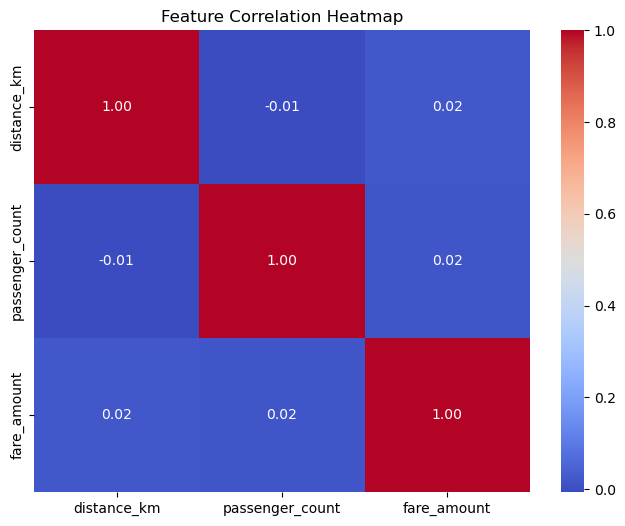

In [22]:
# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()